# Transcriptomic analysis

This is an example notebook performing standard transcriptomic analysis in TCGA-BRCA dataset. 

* (1) Load TCGA-BRCA data (either through API or local file)
* (2) The data is processed (normalised, scaled and outliers are removed)
* (3) QC using PCA to ensure no batch effects
* (5) Perform multvariate analysis (with unsupervised and supervised methods) 
* (4) Perform association analysis using univariate statistics adjusting for cofounder



#### Load libraries

In [214]:
# Import libraries
from pca import pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA

import gseapy
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as  pd
import scanpy as sc
import seaborn as sns

#Import custom functions
import utils

#### Load data

In [215]:
#Load metadata
sample_metadata = pd.read_csv('biospecimen.cart.2023-07-11/sample.tsv', sep = '\t')
clinical_metadata = pd.read_csv('clinical.cart.2023-07-11/clinical.tsv', sep = '\t')

sample_metadata = sample_metadata[sample_metadata.project_id == 'TCGA-BRCA']#.merge(clinical_metadata, how = 'left', on = ['case_id', 'case_submitter_id'])
sample_metadata = sample_metadata.loc[:, (sample_metadata != sample_metadata.iloc[0]).any()] #erase constant cols (n= 147)
sample_metadata.set_index('sample_submitter_id', inplace = True)

sample_metadata.head()

,case_id,case_submitter_id,sample_id,composition,days_to_collection,days_to_sample_procurement,initial_weight,is_ffpe,oct_embedded,pathology_report_uuid,preservation_method,sample_type,sample_type_id,tumor_descriptor
sample_submitter_id,,,,,,,,,,,,,,
TCGA-E2-A154-01A,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,093150bc-9ea8-4729-8693-32fe1d9690d2,Not Reported,461,'--,400.0,False,false,8F8DCA87-B27A-429C-952A-186F8D4502AE,'--,Primary Tumor,01,Not Reported
TCGA-E2-A154-10A,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,4576b0e9-023b-4735-8c17-8a3a22cf9c10,Not Reported,461,'--,'--,False,false,'--,'--,Blood Derived Normal,10,Not Reported
TCGA-E2-A154-01Z,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,f2792f6c-5eb3-4023-84be-06573ce00062,'--,'--,0,'--,True,No,'--,FFPE,Primary Tumor,01,'--
TCGA-LL-A5YM-10A,e9a12df9-024e-4cbc-b6bf-e4e87485fa90,TCGA-LL-A5YM,c81fa4f8-d7db-497e-925b-818b165a9f7a,Not Reported,131,'--,'--,False,false,'--,'--,Blood Derived Normal,10,Not Reported
TCGA-LL-A5YM-01A,e9a12df9-024e-4cbc-b6bf-e4e87485fa90,TCGA-LL-A5YM,cf5fda71-8fba-43fc-91f3-e4baa36571dd,Not Reported,131,'--,280.0,False,false,B169A5B5-27CD-48A6-A8D7-C14D3824A20A,'--,Primary Tumor,01,Not Reported


In [218]:
importlib.reload(utils)

NameError: name 'sample_metadata' is not defined

In [216]:
# Load TCGA-BRCA transcriptomics
tcga_df = utils.load_transcriptomics(source = 'gdc', samples = sample_metadata) #Options are GDC or API


NameError: name 'sample_metadata' is not defined

In [ ]:
## Download and transform the data, or load the parquet file version if already done
# download_tcga_data_files('gdc_manifest.2023-07-11.txt') #~15min
# tcga_df = tcga_import_utils.format_tcga_rnaseq(gdc_sample_sheet = 'gdc_sample_sheet.2023-07-11.tsv', 
#                                    root_dir = 'gdc_download_20230711_113556.889465',
# 
#                                    workflow_type = 'tpm_unstranded') #~10min

## Save the data in a parquet format
# tcga_df.to_parquet('tcga_unstranded.parquet')

## Read the data from parquet if available in workspace
#tcga_df = pd.read_parquet("tpm_unstranded.parquet")
#tcga_df = tcga_df.set_index('gene_name').drop(columns= ['gene_id'])

In [4]:
tcga_gex = pd.read_csv('EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep = '\t').set_index('gene_id').rename(columns = lambda x: x[:-12])
tcga_df = tcga_gex[[col for col in tcga_gex.columns if col in sample_metadata.index.to_list()]]
tcga_df.head()

,TCGA-3C-AAAU-01A,TCGA-3C-AALI-01A,TCGA-3C-AALJ-01A,TCGA-3C-AALK-01A,TCGA-4H-AAAK-01A,TCGA-5L-AAT0-01A,TCGA-5L-AAT1-01A,TCGA-5T-A9QA-01A,TCGA-A1-A0SB-01A,TCGA-A1-A0SD-01A,...,TCGA-UL-AAZ6-01A,TCGA-UU-A93S-01A,TCGA-V7-A7HQ-01A,TCGA-W8-A86G-01A,TCGA-WT-AB41-01A,TCGA-WT-AB44-01A,TCGA-XX-A899-01A,TCGA-XX-A89A-01A,TCGA-Z7-A8R5-01A,TCGA-Z7-A8R6-01A
gene_id,,,,,,,,,,,,,,,,,,,,,
?|100130426,0.0000,0.0000,0.9066,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
?|100133144,16.3644,9.2659,11.6228,12.0894,6.8468,3.9889,0.0000,1.4644,15.3396,9.5178,...,0.3992,4.3126,0.0000,5.5624,0.0000,0.0000,14.3858,22.3240,2.2638,6.8865
?|100134869,12.9316,17.3790,9.2294,11.0799,14.4298,13.6090,10.5949,8.9958,14.3935,11.3241,...,14.3720,10.8828,3.0792,14.3711,6.3091,3.2580,21.4409,27.2744,7.2933,24.7795
?|10357,52.1503,69.7553,154.2970,143.8640,84.2128,114.2570,115.9980,107.5630,116.3870,60.2630,...,135.6240,136.1290,29.9974,128.3150,53.6278,42.2643,137.7760,64.1427,85.0461,167.5510
?|10431,408.0760,563.8930,1360.8300,865.5360,766.3830,807.7430,1108.3900,1420.5000,657.2810,977.9180,...,1570.1400,2886.4000,1721.8800,697.6740,1245.2700,1877.4200,652.7560,722.7210,1140.2800,1003.5700


### Processing
To process the data, lowly expressed genes (< 10 TPM) are first removed. 
Following, outliers are detected and removed using Hoetellings T2 and SPE

<Axes: >

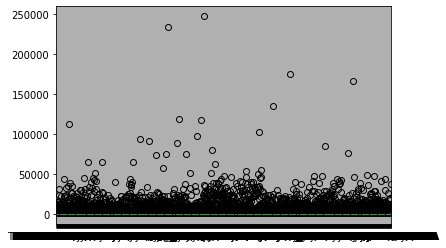

In [ ]:
#The data does not look normalised nor scaled
tcga_df[:100].boxplot() 

In [ ]:
# Filter out genes that are < 10 TPMs in all samples
tcga_df = tcga_df[tcga_df.sum(axis = 1) > 10].copy() #Remove lowly expressed genes

# Log-transform
tcga_df_norm = np.log2(tcga_df + np.finfo(float).eps)
tcga_df_norm.head()

,TCGA-3C-AAAU-01A,TCGA-3C-AALI-01A,TCGA-3C-AALJ-01A,TCGA-3C-AALK-01A,TCGA-4H-AAAK-01A,TCGA-5L-AAT0-01A,TCGA-5L-AAT1-01A,TCGA-5T-A9QA-01A,TCGA-A1-A0SB-01A,TCGA-A1-A0SD-01A,...,TCGA-UL-AAZ6-01A,TCGA-UU-A93S-01A,TCGA-V7-A7HQ-01A,TCGA-W8-A86G-01A,TCGA-WT-AB41-01A,TCGA-WT-AB44-01A,TCGA-XX-A899-01A,TCGA-XX-A89A-01A,TCGA-Z7-A8R5-01A,TCGA-Z7-A8R6-01A
gene_id,,,,,,,,,,,,,,,,,,,,,
?|100130426,-52.000000,-52.000000,-0.141462,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000,...,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000,-52.000000
?|100133144,4.032489,3.211931,3.538886,3.595671,2.775430,1.995991,-52.000000,0.550310,3.939189,3.250628,...,-1.324816,2.108558,-52.000000,2.475707,-52.000000,-52.000000,3.846574,4.480524,1.178747,2.783771
?|100134869,3.692829,4.119273,3.206237,3.469873,3.850979,3.766489,3.405298,3.169252,3.847346,3.501324,...,3.845189,3.443978,1.622556,3.845099,2.657434,1.703987,4.422294,4.769476,2.866572,4.631075
?|10357,5.704604,6.124231,7.269566,7.168562,6.395968,6.836139,6.857956,6.749038,6.862786,5.913201,...,7.083469,7.088831,4.906766,7.003546,5.744909,5.401368,7.106181,6.003213,6.410173,7.388456
?|10431,8.672694,9.139278,10.410271,9.757450,9.581922,9.657753,10.114250,10.472183,9.360366,9.933570,...,10.616677,11.495056,10.749769,9.446409,10.282243,10.874536,9.350400,9.497295,10.155172,9.970926


<Axes: >

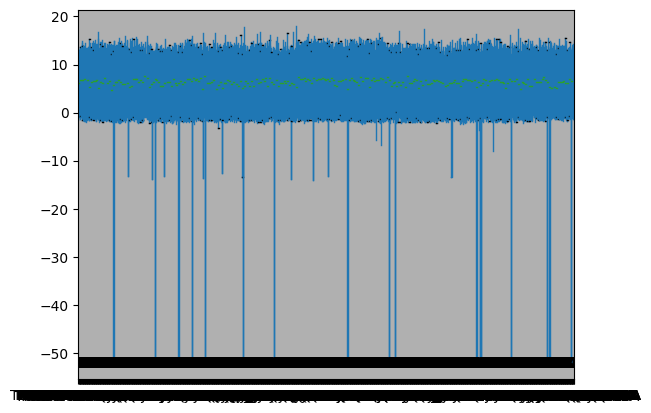

In [ ]:
tcga_df_norm[:100].boxplot()

<b>Outlier detection and removal </b><br>
To detect outliers across the multidimensional space of PCA, the hotellings T2 test can be used. This test computes the chi-square tests across the top n_components: default is PC1-PC5. The reason for not using more PC’s is that it is expected that the highest variance (and thus the outliers) will be seen in the first few components.

The hotellings T2 test outputs a P-value matrix (samples x PCs), which are are subsequently combined using fishers method. This allows to determine outliers with its ranking (strongest to weak). The alpha parameter determines the detection of outliers (default: 0.05).

Outlier can be detected using SPE/DmodX (distance to model) based on the mean and covariance of the first 2 dimensions of X. 

Note that the SPE or Hotelling’s T2 are complementary to each other. Here, the overlap of outliers detected by both methods are removed.

Note 2: it is utterly important to carefully standardize your data as PCA works under the assumption that the data is normal distributed, and is very sensitive to the variance of the variables. Or in other words, large differences between the ranges of variables will dominate over those with small ranges. For this, set "normalize=True" below.

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [75.0%] explained variance using the [19935] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [268] that covers the [75.00%] explained variance.
[pca] >The PCA reduction is performed on the [19935] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[268]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 268 Principal Components explain [75.08%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

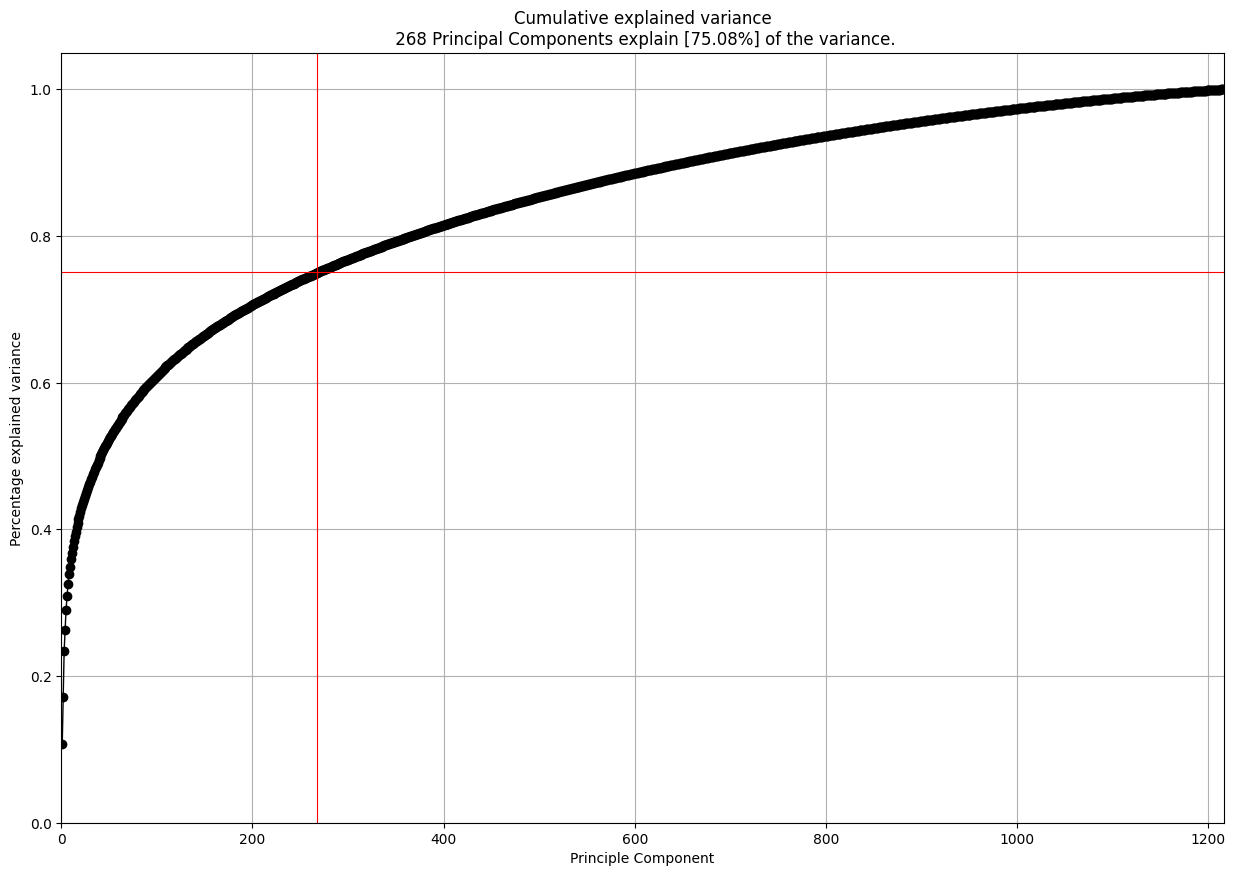

In [8]:
# Initialize pca
model = pca(normalize=True, n_components=0.75, 
            detect_outliers=['ht2', 'spe'], n_std= 3 )

# Fit transform with dataframe
results = model.fit_transform(tcga_df_norm.T)
model.plot()

In [9]:
results

{'loadings':        ?|100130426  ?|100133144  ?|100134869   ?|10357   ?|10431  ?|155060  \
 PC1       0.000290    -0.006891    -0.003163  0.003468  0.010632  0.004953   
 PC2       0.000840    -0.003379     0.000831  0.001909 -0.005233  0.003613   
 PC3       0.000115     0.002961     0.001888  0.010467  0.009478 -0.009743   
 PC4      -0.003472    -0.006789    -0.007084 -0.002825  0.007593 -0.008141   
 PC5      -0.001163    -0.006373    -0.007746 -0.003777  0.010114 -0.023010   
 ...            ...          ...          ...       ...       ...       ...   
 PC264     0.005050     0.000697     0.019133  0.004917 -0.005198  0.006708   
 PC265    -0.009533     0.011350     0.004852  0.003357 -0.004657 -0.008851   
 PC266     0.014474    -0.007101     0.002860  0.006315 -0.000430 -0.002640   
 PC267     0.002523    -0.013231     0.011555 -0.012249 -0.011656 -0.002554   
 PC268    -0.027531     0.006753    -0.008278  0.004002  0.002193 -0.005680   
 
         ?|26823  ?|280660  ?|317712  

In [10]:
#Top variable features / genes->|loading| (abs) 
model.results['topfeat']

,PC,feature,loading,type
0,PC1,TTBK2|146057,-0.019198,best
1,PC2,GYPC|2995,0.024057,best
2,PC3,SUV39H2|79723,0.023703,best
3,PC4,CARD11|84433,-0.028084,best
4,PC5,RBM33|155435,-0.026618,best
...,...,...,...,...
19952,PC187,ZYG11A|440590,0.036563,weak
19953,PC1,ZYG11B|79699,-0.016868,weak
19954,PC2,ZYX|7791,0.018531,weak
19955,PC28,ZZEF1|23140,0.020563,weak


In [11]:
#Print outliers (denoted by y_bool = True, y_bool_spe = True)
print(results['outliers'])

                        y_proba          p_raw      y_score  y_bool  \
TCGA-3C-AAAU-01A   1.000000e+00   9.735349e-01   474.480950   False   
TCGA-3C-AALI-01A   1.000000e+00   5.080220e-01   534.675810   False   
TCGA-3C-AALJ-01A   1.000000e+00   5.228327e-01   533.462114   False   
TCGA-3C-AALK-01A   1.000000e+00   1.000000e+00   234.334251   False   
TCGA-4H-AAAK-01A   1.000000e+00   1.000000e+00   239.062987   False   
...                         ...            ...          ...     ...   
TCGA-WT-AB44-01A  5.832999e-183  5.424929e-184  2103.127730    True   
TCGA-XX-A899-01A   1.000000e+00   1.000000e+00   234.768684   False   
TCGA-XX-A89A-01A   1.000000e+00   1.000000e+00   272.267067   False   
TCGA-Z7-A8R5-01A  1.749336e-116  4.031393e-117  1673.255967    True   
TCGA-Z7-A8R6-01A   1.000000e+00   1.000000e+00   361.367466   False   

                  y_bool_spe  y_score_spe  
TCGA-3C-AAAU-01A       False    34.710335  
TCGA-3C-AALI-01A       False    54.151641  
TCGA-3C-AALJ-01

[datazets] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'Outliers marked using Hotellings T2 method.'}, xlabel='PC1 (10.6% expl.var)', ylabel='PC2 (6.50% expl.var)'>)

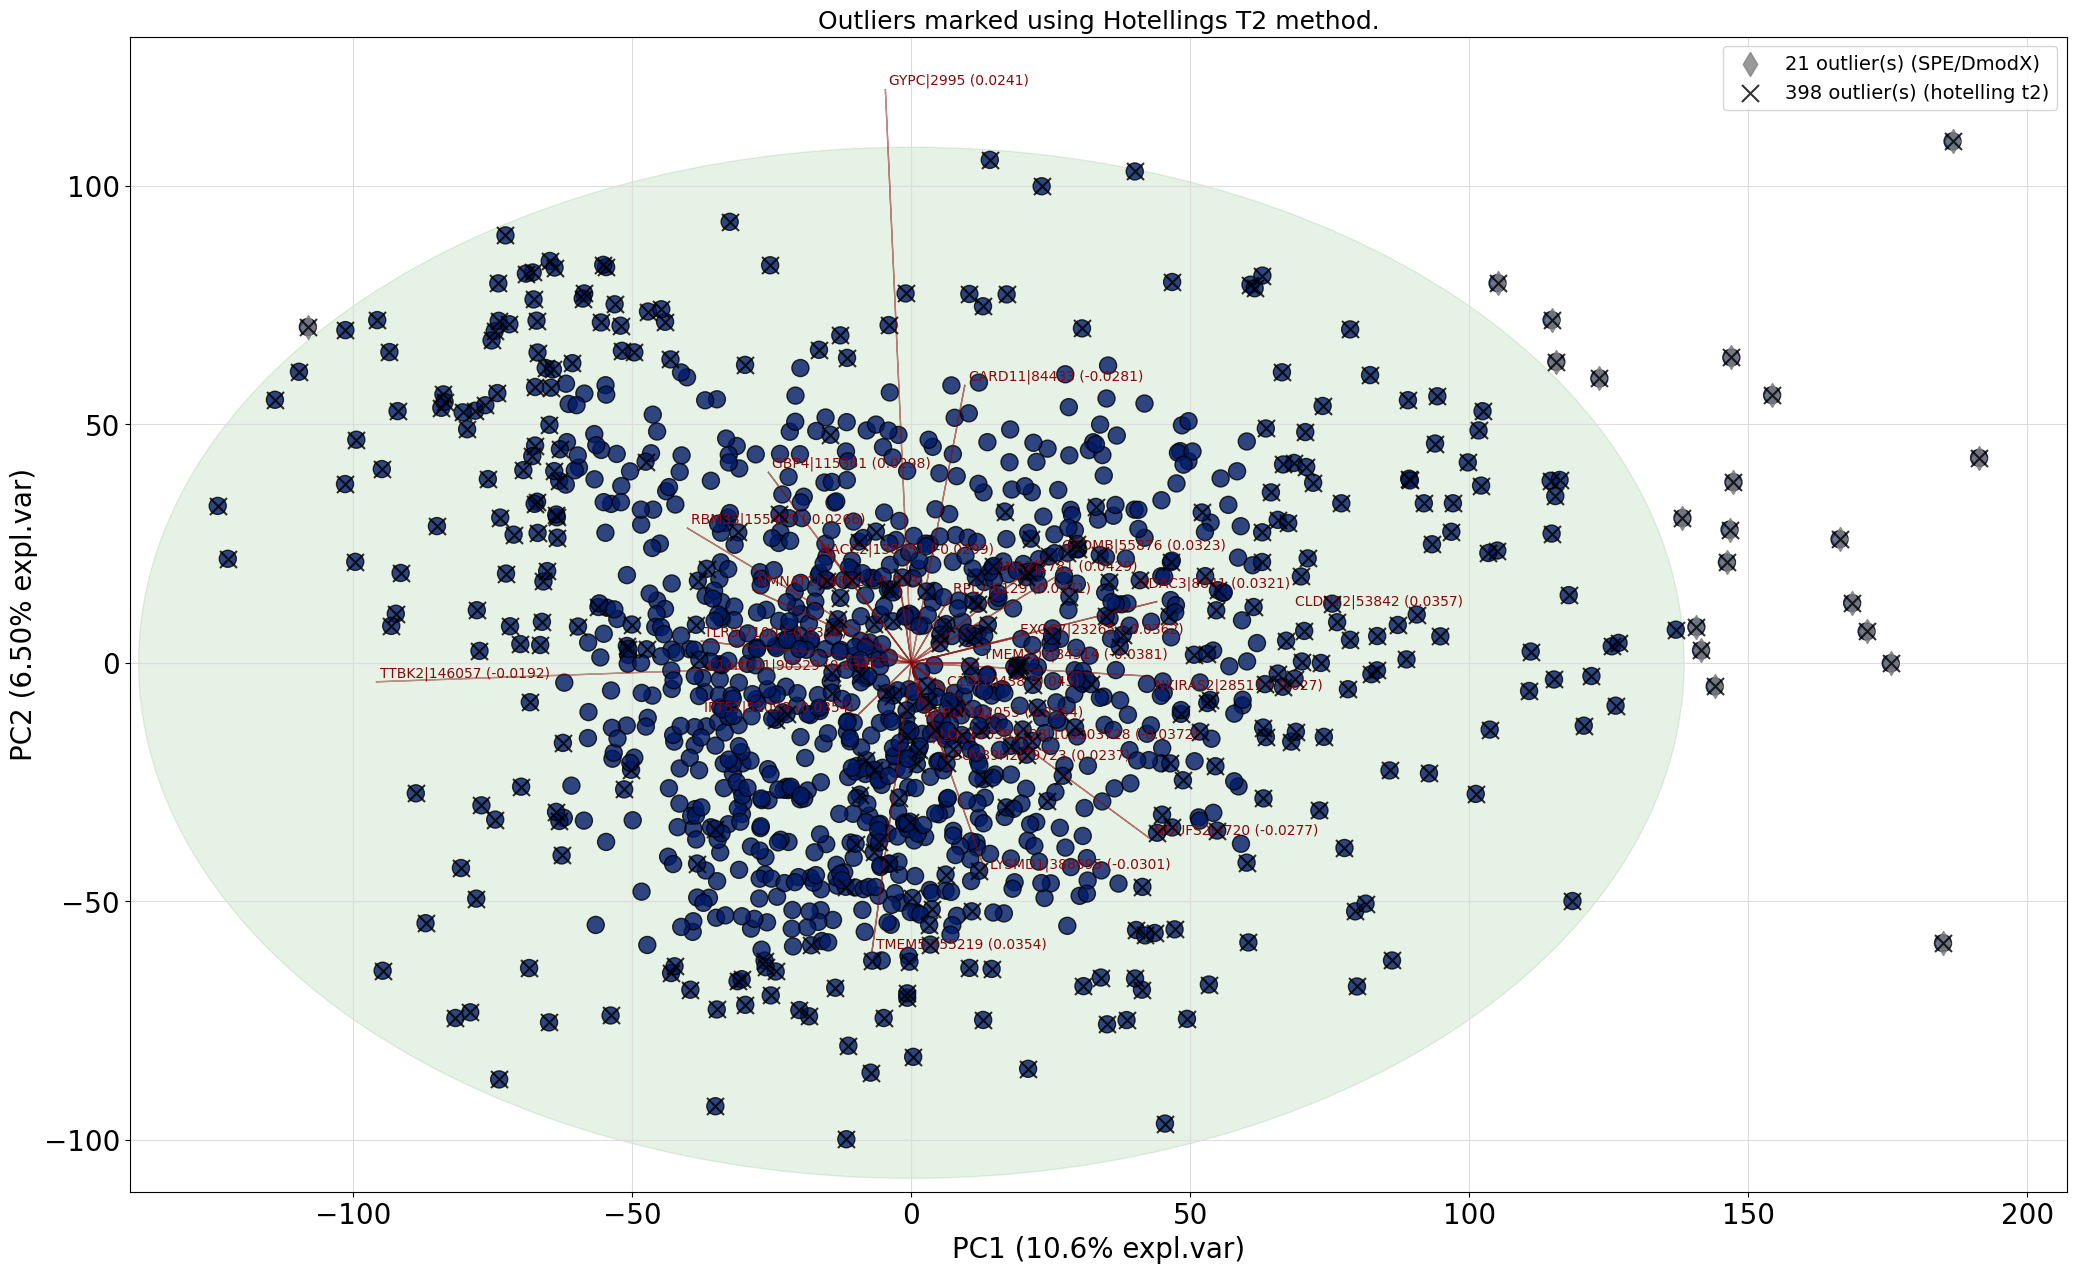

In [12]:
# Plot Hotellings T2 ellipse with data points as rombus if SPE-detected outlier, and cross if HT2-dected outlier
model.biplot(HT2=True, 
             SPE = True,
             fontsize = 10 ,title='Outliers marked using Hotellings T2 method.')

In [13]:
# Get the outliers using SPE/DmodX method
tcga_df_norm.T.loc[results['outliers']['y_bool_spe'], :]

# Grab the overlapping outliers between HT2 and SPE
I_overlap = np.logical_and(results['outliers']['y_bool'], 
                           results['outliers']['y_bool_spe'])

# Remove outlier outliers
tcga_df_rm_outliers = tcga_df_norm.T.loc[~I_overlap, :]

tcga_df_rm_outliers # 1194 rows × 19935 columns

gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|155060,?|26823,?|280660,?|317712,?|340602,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
TCGA-3C-AAAU-01A,-52.000000,4.032489,3.692829,5.704604,8.672694,10.213116,-52.000000,-52.000000,-52.0,0.785174,...,8.699829,9.864120,7.017833,9.976965,10.695663,8.013987,10.238847,11.776125,10.887929,10.205133
TCGA-3C-AALI-01A,-52.000000,3.211931,4.119273,6.124231,9.139278,9.011342,0.121015,-0.878852,-52.0,7.170927,...,10.181562,9.914681,5.902438,8.809328,10.391372,7.632828,9.237423,12.426427,10.364846,8.667974
TCGA-3C-AALJ-01A,-0.141462,3.538886,3.206237,7.269566,10.410271,9.209507,-52.000000,-52.000000,-52.0,-52.000000,...,8.254660,11.305651,5.143969,9.060691,9.586487,8.374266,9.055784,12.414355,9.880935,8.992992
TCGA-3C-AALK-01A,-52.000000,3.595671,3.469873,7.168562,9.757450,9.110486,-1.273343,-52.000000,-52.0,-52.000000,...,8.623903,9.384993,5.782065,8.773907,9.754689,7.454702,9.246420,12.474555,9.609426,9.453001
TCGA-4H-AAAK-01A,-52.000000,2.775430,3.850979,6.395968,9.581922,8.027082,-1.232769,-52.000000,-52.0,-1.232769,...,8.664309,9.397606,5.612830,8.728788,10.035885,3.811738,9.599439,11.980747,9.700292,9.784147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01A,-52.000000,-52.000000,1.703987,5.401368,10.874536,9.460540,2.025915,-52.000000,-52.0,-0.296013,...,7.228953,7.498402,4.610871,7.927985,9.594248,6.622847,8.300174,13.416943,9.645032,8.791446
TCGA-XX-A899-01A,-52.000000,3.846574,4.422294,7.106181,9.350400,8.738650,1.462524,-52.000000,-52.0,1.462524,...,8.833039,8.836325,6.147024,9.330247,10.306677,4.410056,9.426661,12.321395,10.917268,9.388187
TCGA-XX-A89A-01A,-52.000000,4.480524,4.769476,6.003213,9.497295,8.556414,-1.081919,-52.000000,-52.0,4.127435,...,9.050387,9.439580,5.604481,8.415830,10.425772,7.360926,9.544601,12.419318,10.489256,9.897404
TCGA-Z7-A8R5-01A,-52.000000,1.178747,2.866572,6.410173,10.155172,7.977669,-0.743472,-52.000000,-52.0,-52.000000,...,7.435537,8.014796,5.011460,7.957009,9.637032,5.699516,8.982788,12.704688,9.559211,9.552341


In [14]:
# Standardise the data with z-transformation
tcga_df_transformed = pd.DataFrame(StandardScaler().fit_transform(tcga_df_rm_outliers), 
                                   index= tcga_df_rm_outliers.index, #index are samples
                                   columns=tcga_df_rm_outliers.columns) #columns are genes 

tcga_df_transformed.head()

gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|155060,?|26823,?|280660,?|317712,?|340602,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
TCGA-3C-AAAU-01A,-0.149182,0.329244,0.292739,-1.734537,-2.380821,2.748380,-1.320321,-0.176192,-0.050181,1.209995,...,0.021023,0.542331,1.642402,1.417056,1.682678,0.644422,0.847815,-0.020980,1.120096,0.639724
TCGA-3C-AALI-01A,-0.149182,0.257531,0.366656,-1.008878,-1.497762,1.535629,0.784786,5.550217,-0.050181,1.458568,...,2.215866,0.584168,-0.070205,-0.336980,0.815319,0.531309,-1.042075,0.917797,0.229364,-2.011773
TCGA-3C-AALJ-01A,6.843738,0.286105,0.208397,0.971746,0.907731,1.735605,-1.320321,-0.176192,-0.050181,-0.844731,...,-0.638391,1.735103,-1.234778,0.040619,-1.478948,0.751338,-1.384864,0.900369,-0.594665,-1.451138
TCGA-3C-AALK-01A,-0.149182,0.291068,0.254094,0.797079,-0.327804,1.635679,0.728469,-0.176192,-0.050181,-0.844731,...,-0.091443,0.145886,-0.255028,-0.390189,-0.999501,0.478448,-1.025095,0.987274,-1.057004,-0.657654
TCGA-4H-AAAK-01A,-0.149182,0.219383,0.320152,-0.538965,-0.660010,0.542380,0.730108,-0.176192,-0.050181,1.131444,...,-0.031592,0.156322,-0.514876,-0.457968,-0.197972,-0.602638,-0.358877,0.274412,-0.902272,-0.086449


### QC analysis
PCA plot coloured based on relevant metadata -> ensure no batch effects


In [15]:
pca_to_plot = tcga_df_transformed.join(sample_metadata[['sample_type']])
pca_to_plot.head()

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|155060,?|26823,?|280660,?|317712,?|340602,...,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,sample_type
TCGA-3C-AAAU-01A,-0.149182,0.329244,0.292739,-1.734537,-2.380821,2.748380,-1.320321,-0.176192,-0.050181,1.209995,...,0.542331,1.642402,1.417056,1.682678,0.644422,0.847815,-0.020980,1.120096,0.639724,Primary Tumor
TCGA-3C-AALI-01A,-0.149182,0.257531,0.366656,-1.008878,-1.497762,1.535629,0.784786,5.550217,-0.050181,1.458568,...,0.584168,-0.070205,-0.336980,0.815319,0.531309,-1.042075,0.917797,0.229364,-2.011773,Primary Tumor
TCGA-3C-AALJ-01A,6.843738,0.286105,0.208397,0.971746,0.907731,1.735605,-1.320321,-0.176192,-0.050181,-0.844731,...,1.735103,-1.234778,0.040619,-1.478948,0.751338,-1.384864,0.900369,-0.594665,-1.451138,Primary Tumor
TCGA-3C-AALK-01A,-0.149182,0.291068,0.254094,0.797079,-0.327804,1.635679,0.728469,-0.176192,-0.050181,-0.844731,...,0.145886,-0.255028,-0.390189,-0.999501,0.478448,-1.025095,0.987274,-1.057004,-0.657654,Primary Tumor
TCGA-4H-AAAK-01A,-0.149182,0.219383,0.320152,-0.538965,-0.660010,0.542380,0.730108,-0.176192,-0.050181,1.131444,...,0.156322,-0.514876,-0.457968,-0.197972,-0.602638,-0.358877,0.274412,-0.902272,-0.086449,Primary Tumor


[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [19935] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [854] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [19935] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[854]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[colourmap] >Add transparency to RGB colors (last column)


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '854 Principal Components explain [95.02%] of the variance'}, xlabel='PC1 (9.61% expl.var)', ylabel='PC2 (6.59% expl.var)'>)

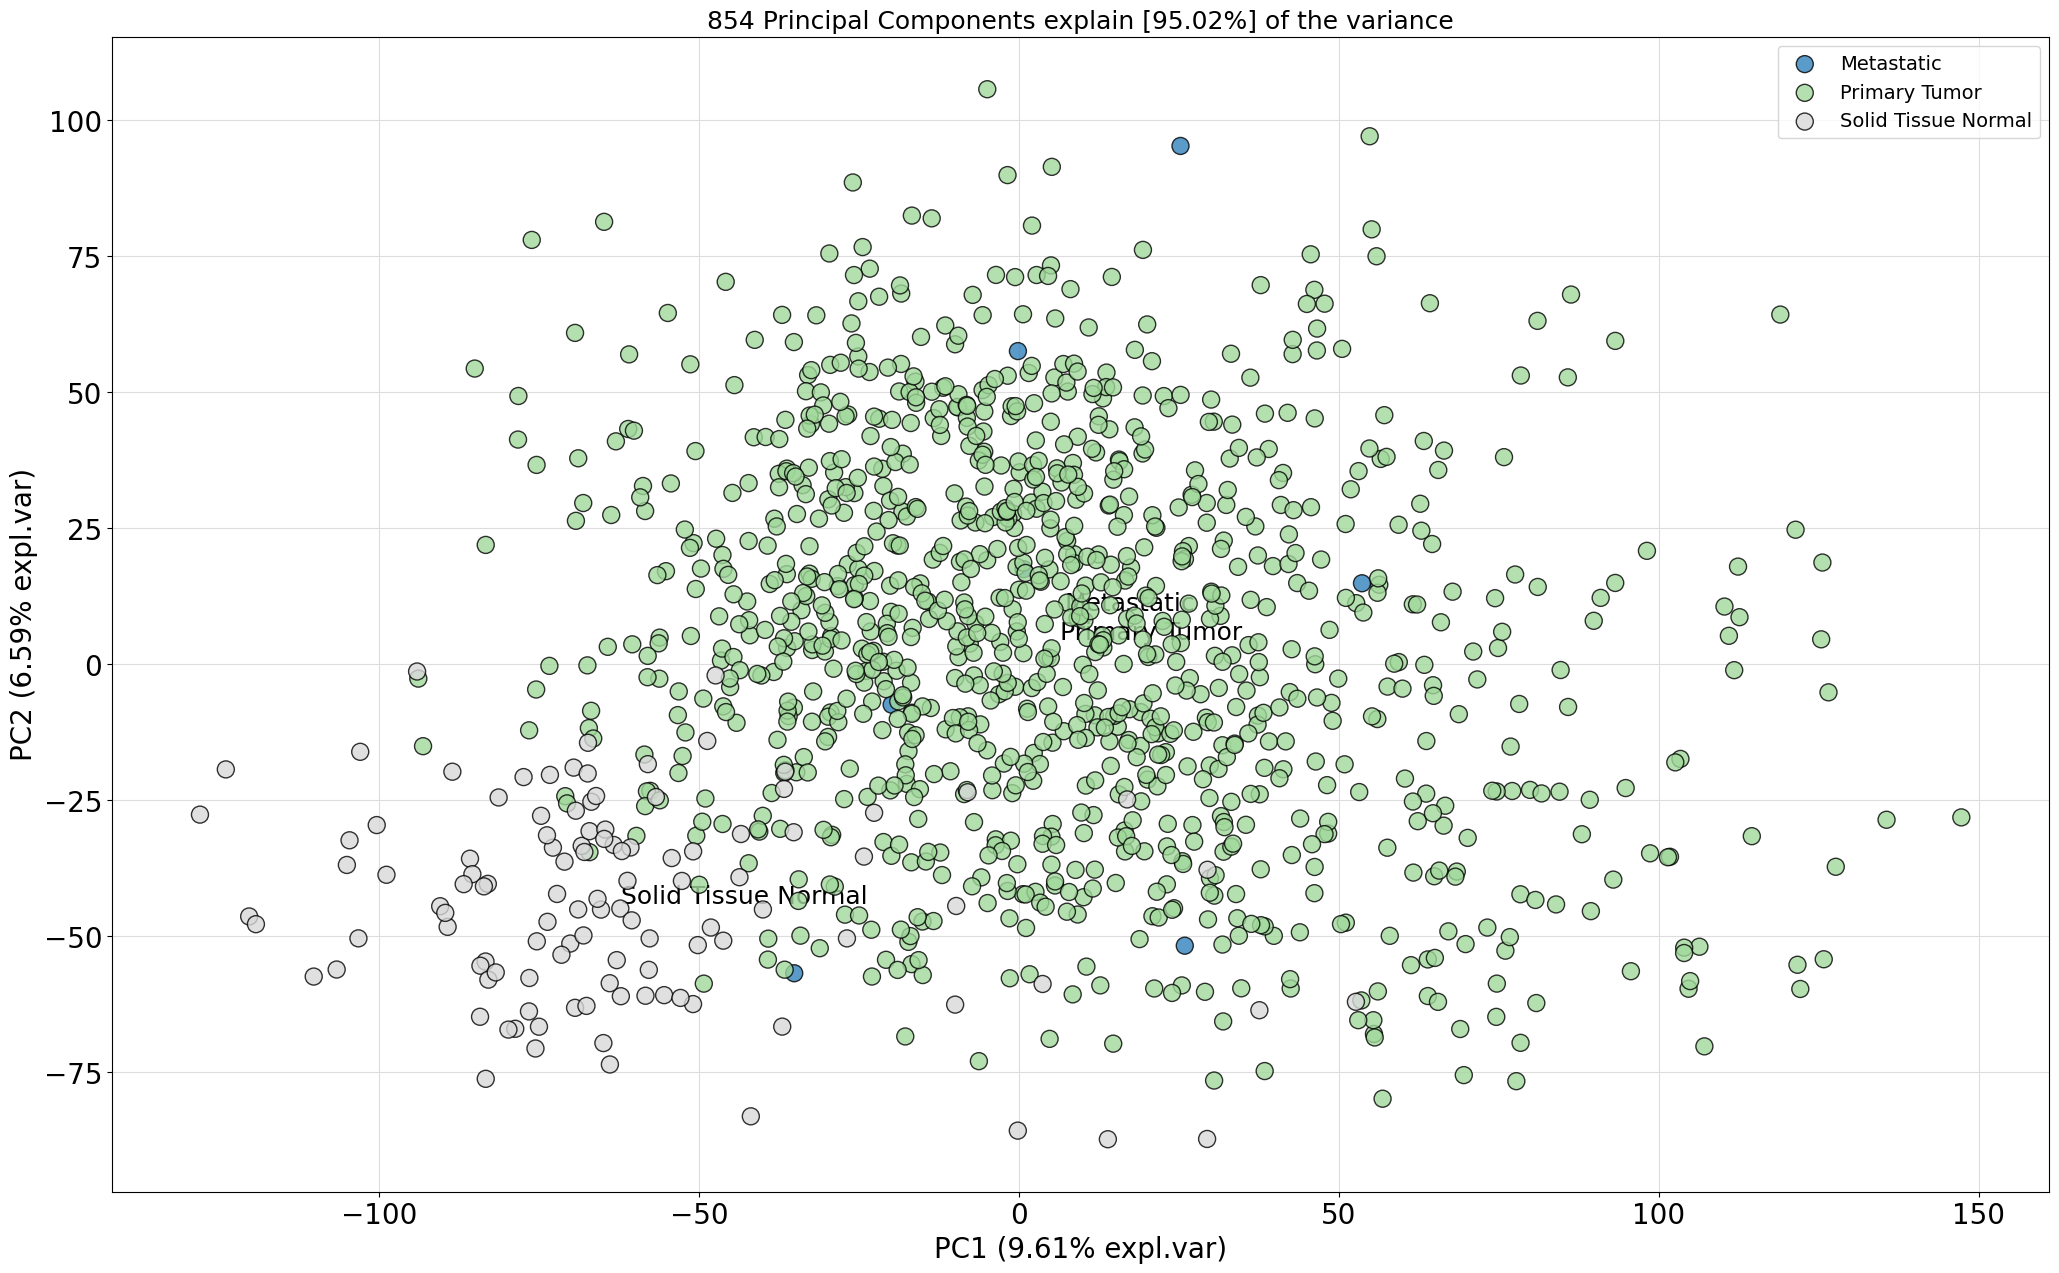

In [16]:
#from pca import pca
model = pca(normalize=False)

# Fit transform and include the column labels and row labels
results = model.fit_transform(pca_to_plot.loc[:, pca_to_plot.columns != 'sample_type'], 
                              col_labels=pca_to_plot.loc[:, pca_to_plot.columns != 'sample_type'].columns, 
                              row_labels=pca_to_plot.sample_type.to_list())

model.scatter() #No batch effects observed

### Association analysis with linear regression
The aim of this analysis is to compute the association between the expression of a gene of interest and metadata variables of interest using univariate stats (e.g. regression analysis adjusting for cofounders). <br>

Statistical procedures uses for univarate analysis include t-test, ANOVA, Mann-Whitney U test, Wilcoxon signed-rank test , and logistic regression. To 

In [207]:
pancanmirs = pd.read_csv('pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.csv').set_index('Genes')
pancanmirs = pancanmirs[pancanmirs.Correction == 'Corrected'].drop(columns = ['Correction']).rename(columns = lambda x: x[:-12])
tcga_miRs_df = pancanmirs.copy()[[col for col in pancanmirs.columns if col in tcga_df.columns.to_list()]]
tcga_miRs_df.head()


,TCGA-AO-A03O-01A,TCGA-A8-A06R-01A,TCGA-A8-A07Z-01A,TCGA-A8-A09T-01A,TCGA-AN-A0AR-01A,TCGA-BH-A0DZ-01A,TCGA-A8-A081-01A,TCGA-A8-A08T-01A,TCGA-A8-A095-01A,TCGA-A8-A09G-01A,...,TCGA-PL-A8LV-01A,TCGA-PL-A8LY-01A,TCGA-S3-AA15-01A,TCGA-UL-AAZ6-01A,TCGA-5L-AAT0-01A,TCGA-5T-A9QA-01A,TCGA-Z7-A8R6-01A,TCGA-E2-A9RU-01A,TCGA-S3-AA0Z-01A,TCGA-UU-A93S-01A
Genes,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,1.114995,6.179001,5.525009,8.829309,79.781208,11.192414,9.500794,17.103314,5.505343,2.547407,...,2.563125,4.027011,7.069357,2.471248,2.186720,2.750761,2.497093,2.409076,2.208895,1.481778
hsa-let-7a-3p,84.739652,36.793143,59.854269,66.850484,44.677476,27.981036,16.410462,51.309943,33.032058,24.200369,...,21.145781,37.048502,27.461734,22.241236,31.707439,73.170255,48.443612,25.842815,33.133420,21.485785
hsa-let-7a-5p,18474.730860,12000.743730,24312.803930,24291.952460,16576.141590,16276.314260,10607.204370,31641.131420,24389.169690,9638.752178,...,25595.686260,38676.756390,21613.472020,10800.453830,40764.695950,54019.453940,41914.960990,19119.522140,56950.111600,28990.886750
hsa-let-7b-3p,13.379945,29.490687,174.037797,74.418464,29.519047,55.453326,19.001587,100.054389,67.565572,34.389998,...,12.495234,26.309805,19.032885,7.413745,23.780579,64.917971,30.464539,23.433739,38.980494,11.219179
hsa-let-7b-5p,6458.425166,10808.758230,78060.095530,46828.133710,20134.383470,50900.556920,6155.650640,117010.614300,60903.606950,12886.059570,...,8690.275184,25179.826180,11733.501550,2689.542006,24406.664300,35018.844090,17739.351400,12438.716390,23776.931790,11585.707060


In [208]:
# Log-transform
tcga_miRs_df = np.log2(tcga_miRs_df + np.finfo(float).eps)

# Standardise the data with z-transformation
tcga_miRs_df = pd.DataFrame(StandardScaler().fit_transform(tcga_miRs_df), 
                                   index= tcga_miRs_df.index, #index are samples
                                   columns=tcga_miRs_df.columns) #columns are genes 

tcga_miRs_df.head()

,TCGA-AO-A03O-01A,TCGA-A8-A06R-01A,TCGA-A8-A07Z-01A,TCGA-A8-A09T-01A,TCGA-AN-A0AR-01A,TCGA-BH-A0DZ-01A,TCGA-A8-A081-01A,TCGA-A8-A08T-01A,TCGA-A8-A095-01A,TCGA-A8-A09G-01A,...,TCGA-PL-A8LV-01A,TCGA-PL-A8LY-01A,TCGA-S3-AA15-01A,TCGA-UL-AAZ6-01A,TCGA-5L-AAT0-01A,TCGA-5T-A9QA-01A,TCGA-Z7-A8R6-01A,TCGA-E2-A9RU-01A,TCGA-S3-AA0Z-01A,TCGA-UU-A93S-01A
Genes,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,0.282461,0.311942,0.473347,0.400305,0.538398,0.452784,0.448803,0.582751,0.421289,0.494178,...,0.281583,0.309467,0.342977,0.387971,0.326596,0.347750,0.309149,0.342219,0.198687,0.183382
hsa-let-7a-3p,0.571336,0.448489,0.616266,0.536507,0.501175,0.512091,0.483216,0.646108,0.536109,0.624901,...,0.434464,0.473343,0.442496,0.530229,0.517992,0.568566,0.514531,0.504314,0.421079,0.408926
hsa-let-7a-5p,0.930505,0.891420,0.976579,0.933156,0.880985,0.924126,0.890684,1.016599,0.959332,0.972550,...,0.948754,0.986620,0.931522,0.930699,1.030383,1.013056,0.982951,0.955629,1.032840,1.016810
hsa-let-7b-3p,0.448213,0.431557,0.680290,0.543722,0.474569,0.556364,0.492447,0.684621,0.581967,0.645305,...,0.396350,0.448067,0.415609,0.459100,0.497402,0.560512,0.482404,0.497629,0.434425,0.354123
hsa-let-7b-5p,0.860398,0.883414,1.046549,0.977315,0.893469,0.997923,0.856421,1.092020,1.017977,0.989409,...,0.870494,0.954926,0.886723,0.840690,0.993669,0.983883,0.923395,0.926261,0.961110,0.939450


In [209]:
tcga_miRs_df.loc[['hsa-miR-361-3p']]

,TCGA-AO-A03O-01A,TCGA-A8-A06R-01A,TCGA-A8-A07Z-01A,TCGA-A8-A09T-01A,TCGA-AN-A0AR-01A,TCGA-BH-A0DZ-01A,TCGA-A8-A081-01A,TCGA-A8-A08T-01A,TCGA-A8-A095-01A,TCGA-A8-A09G-01A,...,TCGA-PL-A8LV-01A,TCGA-PL-A8LY-01A,TCGA-S3-AA15-01A,TCGA-UL-AAZ6-01A,TCGA-5L-AAT0-01A,TCGA-5T-A9QA-01A,TCGA-Z7-A8R6-01A,TCGA-E2-A9RU-01A,TCGA-S3-AA0Z-01A,TCGA-UU-A93S-01A
Genes,,,,,,,,,,,,,,,,,,,,,
hsa-miR-361-3p,0.552535,0.467982,0.642703,0.541007,0.530917,0.566764,0.619315,0.628221,0.59786,0.681662,...,0.607787,0.6001,0.619786,0.65448,0.608793,0.657016,0.610459,0.592493,0.616791,0.647641


In [210]:
gene_of_interest = 'FANCA'
sns.set(font_scale=1)
ax = sns.boxplot(data=pca_to_plot[[gene_of_interest, discrete_variable]], 
                 x='sample_type', 
                 y=gene_of_interest, 
                 order= ['Solid Tissue Normal', 'Primary Tumor', 'Metastatic'] )

ax.set_title(f'{gene_of_interest} expression across tumour types in TCGA BRCA patients')
ax.set_ylabel(f'{gene_of_interest} exprs [log2(tpm+1e-16)]')


KeyError: "['FANCA'] not in index"

For gene signatures - here the miR-361-3p inhibition signature is used. This signature was generated from differential gene expression performed on  RNA-seq data generated from MCF7 (breast cancer) tumour xenografts treated with ASO-361-3p vs AS-NC (negative contrl oligo). 

In [ ]:
miR361_signature = pd.read_csv('tt_table_GR_EdgeR.txt', sep=',', index_col= 'Unnamed: 0')
miR361_signature[miR361_signature.FDR < 0.05] #194 signifcatly DE

miR361_signature = miR361_signature[(miR361_signature.FDR < 0.05) & 
                                    (miR361_signature.logFC > 1)].symbol.dropna().to_list()
miR361_signature

['IGFBP5',
 'AZGP1',
 'ACP5',
 'UGT2B15',
 'UGT2B11',
 'SLC26A2',
 'SERPINA5',
 'CCNP',
 'RNU1-3',
 'CPB1',
 'MIR3648-2',
 'RNVU1-7',
 'ELF5',
 'ADRA2A',
 'RNU1-1',
 'MME',
 'ZBTB16',
 'MGP',
 'TMEM178A',
 'SORBS1',
 'RNU1-28P',
 'RMRP',
 'CRAT',
 'RNU4-2',
 'PIP',
 'RN7SK',
 'ERP27',
 'RNU4-1',
 'MAT1A']

In [ ]:
tcga_df_transformed.head()

gene_name,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC020765.6,AL139280.3,AC010980.1,AC004233.4,AC092910.4,AC073611.1,AC078856.1,AL592295.6,AL391628.1,AP006621.6
TCGA-B6-A0RH-01A,-0.744215,-3.433165,-0.025829,-0.178004,0.105926,-0.650245,0.081204,1.426544,-1.008611,0.943971,...,-0.903350,-0.587085,0.278777,-0.790450,-0.348996,-0.134847,-0.338266,0.617153,0.202529,1.056389
TCGA-BH-A1FU-11A,0.697732,0.528841,-0.542342,0.471161,-0.283669,0.724068,1.158106,-0.536684,0.794864,0.675975,...,-0.903350,1.672352,0.303910,-0.790450,-0.348996,0.746330,-0.338266,-0.013943,0.380362,0.052360
TCGA-BH-A1FU-01A,0.903219,0.116408,-0.789802,0.049510,0.366077,-0.042595,0.859884,-0.463776,1.653701,1.501232,...,-0.903350,-0.587085,0.181343,1.252812,-0.348996,-0.940007,-0.338266,-0.707953,-0.061901,0.696939
TCGA-AR-A0TX-01A,0.112813,0.278592,3.506811,1.419005,-0.232163,1.020225,0.513708,-1.213092,-0.718163,1.101585,...,1.079362,-0.587085,-3.217720,-0.790450,-0.348996,0.085007,-0.338266,0.041370,0.221637,0.336230
TCGA-A1-A0SE-01A,0.987356,0.308741,-0.778762,0.427815,1.316861,-1.078011,0.163354,-1.422134,-0.456522,1.182745,...,1.082919,1.685255,0.199802,-0.790450,-0.348996,-0.209007,-0.338266,0.983273,-0.022764,0.210467


In [ ]:
# Get the 50% most variable genes
# tcga_df_mad = tcga_df_norm.copy()
# tcga_df_mad['mad'] = tcga_df_mad.mad(axis = 1, skipna = True)
# tcga_df_mad.sort_values(by = 'mad', ascending = False, inplace= True) #Greater MAD <=> greater variability
# tcga_df_mad = tcga_df_mad.iloc[: round(len(tcga_df_mad) /2) ,:].drop(columns= ['mad']) #Select top  50% most  variable  genes
# tcga_df_mad.head()

# Get the most variable genes
# tcga_df_mad = tcga_df_norm.copy()
# tcga_df_mad['mad'] = tcga_df_mad.mad(axis = 1, skipna = True)
# tcga_df_mad.sort_values(by = 'mad', ascending = False, inplace= True) #Greater MAD <=> greater variability
# tcga_df_mad = tcga_df_mad.iloc[: round(len(tcga_df_mad) /2) ,:].drop(columns= ['mad']) #Select top  50% most  variable  genes
# tcga_df_mad.head()


ssGSEA was originally described by Barbie et al. (Nature 2009). Further information about ssGSEA can be in the GenePattern documentation. This notebook uses GSEApy implementation of ssGSEA, which can be downloaded here and is documented here.

In [ ]:
type(miR361_signature)

list

In [ ]:
ss = gseapy.ssgsea(
        data = tcga_df_transformed.T,
        gene_sets =  miR361_signature,
        sample_norm_method = 'rank',
        no_plot = True,
        threads = 4)
es = ss.res2d.copy()


2023-07-13 10:59:28,746 [WARNING] Dropping duplicated gene names, values averaged by gene names!
2023-07-13 11:00:06,105 [ERROR] No supported gene_sets: IGFBP5
2023-07-13 11:00:06,745 [ERROR] No supported gene_sets: AZGP1
2023-07-13 11:00:07,375 [ERROR] No supported gene_sets: ACP5
2023-07-13 11:00:07,979 [ERROR] No supported gene_sets: UGT2B15
2023-07-13 11:00:08,590 [ERROR] No supported gene_sets: UGT2B11
2023-07-13 11:00:09,208 [ERROR] No supported gene_sets: SLC26A2
2023-07-13 11:00:09,863 [ERROR] No supported gene_sets: SERPINA5
2023-07-13 11:00:10,462 [ERROR] No supported gene_sets: CCNP
2023-07-13 11:00:11,113 [ERROR] No supported gene_sets: RNU1-3
2023-07-13 11:00:11,721 [ERROR] No supported gene_sets: CPB1
2023-07-13 11:00:12,308 [ERROR] No supported gene_sets: MIR3648-2
2023-07-13 11:00:12,916 [ERROR] No supported gene_sets: RNVU1-7
2023-07-13 11:00:13,539 [ERROR] No supported gene_sets: ELF5
2023-07-13 11:00:14,134 [ERROR] No supported gene_sets: ADRA2A
2023-07-13 11:00:14,7

KeyboardInterrupt: 

In [ ]:
tcga_df_transformed[['IGFBP5']]

gene_name,IGFBP5
TCGA-B6-A0RH-01A,-0.305060
TCGA-BH-A1FU-11A,0.222676
TCGA-BH-A1FU-01A,0.539890
TCGA-AR-A0TX-01A,-0.356267
TCGA-A1-A0SE-01A,-0.066576
...,...
TCGA-AC-A5XU-01A,-0.318907
TCGA-BH-A0DV-11A,0.133430
TCGA-AR-A0U2-01A,-0.329999
TCGA-BH-A1EW-01A,-0.049447


### Multivariate analysis

Unsupervised ML is applied to TCGA-BRCA data to extract pathway-level molecular signatures. Independent component analysis (ICA) is an unsupervised learning method widely used in signal processing and has been applied to cancer genomics with notable success (). This approach decomposes the molecular profiles into linear combinations of non-Gaussian independent sources or components, each of which is comprised of weighted contributions from individual genes. Therefore, ICA reduces the dimensionality of original data by representing the molecular profile of each sample as weighted sum of several “meta-genes” and the weight of specific meta-gene (mixing scores) in one sample reflects the “activity” of that component in the sample. 

Different from the more conventional dimension reduction method PCA, ICA is able to discover more informative representations of high-dimensional biological signals, which are usually super-Gaussian and contain more close-to-zero values than a normally-distributed sample. Instead, PCA seeks to find uncorrelated factors that explain the variance among the data, and works the best when the underlying components are normally distributed.

In [38]:
n_components = 300
n_runs = 100

ica = FastICA(n_components = n_components, 
              random_state = 100, 
              max_iter = 300)

source_matrix = ica.fit_transform(tcga_df_transformed.T) # Reconstruct signals
latent_ids = ['L'+ str(i) for i in range(n_components)]

loadings = pd.DataFrame(source_matrix.T, 
                        columns=tcga_df_transformed.columns, 
                        index=latent_ids)

factors = pd.DataFrame(ica.mixing_, 
                        index=tcga_df_transformed.index, 
                        columns=latent_ids)

In [44]:
factors.head(2)

,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L290,L291,L292,L293,L294,L295,L296,L297,L298,L299
TCGA-3C-AAAU-01A,0.016598,0.059408,0.062530,-0.011781,0.027792,0.023568,0.065855,-0.020315,-0.031280,-0.018675,...,0.058809,0.014549,-0.009457,-0.026480,-0.009534,-0.046954,-0.002760,0.097360,-0.025826,0.026481
TCGA-3C-AALI-01A,-0.033450,-0.037341,0.126491,0.053249,0.048190,0.053668,0.054329,0.035075,0.009668,0.014333,...,-0.134024,0.027380,-0.015749,-0.058642,-0.022847,-0.053014,0.169765,0.035534,0.198054,-0.019794


In [41]:
sample_metadata.head(2)

,case_id,case_submitter_id,sample_id,composition,days_to_collection,days_to_sample_procurement,initial_weight,is_ffpe,oct_embedded,pathology_report_uuid,preservation_method,sample_type,sample_type_id,tumor_descriptor
sample_submitter_id,,,,,,,,,,,,,,
TCGA-E2-A154-01A,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,093150bc-9ea8-4729-8693-32fe1d9690d2,Not Reported,461,'--,400.0,False,false,8F8DCA87-B27A-429C-952A-186F8D4502AE,'--,Primary Tumor,01,Not Reported
TCGA-E2-A154-10A,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,4576b0e9-023b-4735-8c17-8a3a22cf9c10,Not Reported,461,'--,'--,False,false,'--,'--,Blood Derived Normal,10,Not Reported


In [85]:
factors.head()

,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L290,L291,L292,L293,L294,L295,L296,L297,L298,L299
TCGA-3C-AAAU-01A,0.016598,0.059408,0.062530,-0.011781,0.027792,0.023568,0.065855,-0.020315,-0.031280,-0.018675,...,0.058809,0.014549,-0.009457,-0.026480,-0.009534,-0.046954,-0.002760,0.097360,-0.025826,0.026481
TCGA-3C-AALI-01A,-0.033450,-0.037341,0.126491,0.053249,0.048190,0.053668,0.054329,0.035075,0.009668,0.014333,...,-0.134024,0.027380,-0.015749,-0.058642,-0.022847,-0.053014,0.169765,0.035534,0.198054,-0.019794
TCGA-3C-AALJ-01A,-0.068270,0.033099,-0.001959,0.021278,0.047772,-0.004207,-0.032326,-0.049826,-0.046566,-0.018658,...,-0.004509,0.057485,-0.020635,-0.014356,0.050091,-0.021925,0.007808,0.050155,-0.005039,-0.006497
TCGA-3C-AALK-01A,-0.005469,-0.071406,0.005589,-0.010132,-0.019199,0.006241,0.016355,0.001875,-0.022545,0.021110,...,-0.018503,0.014613,-0.012621,0.023095,-0.012488,0.047485,0.065073,0.017523,0.042844,-0.001108
TCGA-4H-AAAK-01A,-0.017622,0.060400,0.012750,-0.026223,-0.008399,0.012315,-0.028918,0.015262,0.026832,0.053988,...,-0.024687,0.018130,0.001873,0.025223,-0.004195,0.028943,0.010058,-0.051683,-0.008784,-0.002770


In [124]:
from itertools import combinations

users = ["Solid Tissue Normal", "Primary Tumor", "Metastatic"]
for i in list(combinations(users, 2)):
    print(i)

('Solid Tissue Normal', 'Primary Tumor')
('Solid Tissue Normal', 'Metastatic')
('Primary Tumor', 'Metastatic')


In [173]:
def compute_stats(factors:pd.DataFrame, sample_metadata:pd.DataFrame) -> pd.DataFrame: 
    comparisons = [['Solid Tissue Normal', 'Primary Tumor'], 
                    ['Solid Tissue Normal', 'Metastatic'],
                    ['Primary Tumor', 'Metastatic']]

    full_df = factors.join(sample_metadata).reset_index().rename(columns  ={'index': 'sample_ids'})
    
    output = pd.DataFrame(columns= ['latent', 'variable', 'cor', 'pvalue'])

    for latent in factors.columns:
        print(latent)
        df_latent = full_df[['sample_ids', latent, 'sample_type']]
        df_melt = df_latent.melt(id_vars = [latent,'sample_ids'],
                                 var_name = 'metadata', 
                                 value_name = 'metadata_value')
                
        for combination in comparisons:
            print(combination[0])
            print(combination[1])
            u_statistic, p_value = mannwhitneyu(df_melt[df_melt.metadata_value == combination[0]][latent], 
                                                df_melt[df_melt.metadata_value == combination[1]][latent])
            
            
            output = pd.concat([output, 
                                pd.DataFrame({"latent": [latent], 
                                "variable": f'{combination[0]} v {combination[1]}',
                                "cor": u_statistic, 
                                "pvalue": p_value})])
            print('finished!')
            
    return output

In [175]:
output =compute_stats(factors, sample_metadata)
output

L0
Solid Tissue Normal
Primary Tumor
finished!
Solid Tissue Normal
Metastatic
finished!
Primary Tumor
Metastatic


KeyboardInterrupt: 